In [3106]:
import numpy as np 
import pandas as pd
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings #filter and surpress warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer

In [3107]:
mobiles = pd.read_csv('data/mobile-data.csv')

In [3108]:
mobiles.head()

,name,ratings,price,imgURL,corpus
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,Storage64 GBRAM4 SystemAndroid 11Processor Sp...
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,Storage256 GBRAM12 SystemAndroid Q 11Processo...
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,Storage128 SystemiOS 15Processor TypeA15 Bion...


In [3109]:
mobiles.shape

(2546, 5)

In [3110]:
mobiles.isnull().sum()

name        0
ratings     0
price       0
imgURL      0
corpus     12
dtype: int64

In [3111]:
mobiles_clean=mobiles.dropna()

In [3112]:
mobiles_clean.isnull().sum()

name       0
ratings    0
price      0
imgURL     0
corpus     0
dtype: int64

In [3113]:
mobiles_clean.shape

(2534, 5)

In [3114]:
mobiles_clean.loc[:,'corpus'] = mobiles_clean['corpus'].str.lower()

In [3115]:
def extract_storage(corpus):
    match = re.search(r'storage(\d+)', corpus)
    if match:
        return int(match.group(1))
    return None

In [3116]:
mobiles_clean.loc[:, 'storage'] = mobiles_clean['corpus'].apply(extract_storage)

In [3117]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,storage128 systemios 15processor typea15 bion...,128.0


In [3118]:
# Replace variations of brand names with the desired format
mobiles_clean['name'] = mobiles_clean['name'].replace({'APPLE': 'Apple', 'Apple': 'Apple', 'REDMI': 'Redmi', 'Redmi': 'Redmi'}, regex=True)

In [3119]:
def extract_ram(corpus):
    # Enhanced regex pattern to capture various RAM formats
    # This pattern will look for "ram" followed by optional characters (like : or -) 
    # and then capture the numeric value followed by optional "GB" or "gb".
    match = re.search(r'ram\s*[:\-]?\s*(\d+)\s*(gb|g)?', corpus, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

In [3120]:
# Apply the extract_ram function to the corpus column
mobiles_clean['ram'] = mobiles_clean['corpus'].apply(extract_ram)

In [3121]:
def extract_system(corpus):
    match = re.search(r'system(.*?)processor', corpus)
    if match:
        return match.group(1).strip()
    return None

In [3122]:
mobiles_clean.loc[:, 'system'] = mobiles_clean['corpus'].apply(extract_system)

In [3123]:
def extract_processor(corpus):
    match = re.search(r'processor (.*?) ', corpus)
    if match:
        return match.group(1).strip()
    return None

In [3124]:
mobiles_clean.loc[:, 'processor'] = mobiles_clean['corpus'].apply(extract_processor)

In [3125]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage,ram,system,processor
0,"Redmi Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0,6.0,android 12,typemediatek
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0,6.0,android pie 9.0,typemediatek
2,"Redmi Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0,4.0,android 11,speed2.4
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0,12.0,android q 11,typequalcomm
4,"Apple iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,storage128 systemios 15processor typea15 bion...,128.0,NaN,ios 15,typea15


In [3126]:
unique_systems = mobiles_clean['system'].unique()
unique_processors = mobiles_clean['processor'].unique()

In [3127]:
unique_systems

array(['android 12', 'android pie 9.0', 'android 11', 'android q 11',
       'ios 15', 'ios 9', 'android 13', 'android pie 9',
       'android nougat 7', 'android 10', 'ios 16', None,
       'android q android q 12.5', 'android oreo 8.1',
       'android marshmallow 6.0.1', 'android oreo 8.1.0',
       'android 13 (go edition)', 'android android 12', 'android q 10',
       'ios 14.2', 'android pie android v9.0 (pie)', 'android andriod 11',
       'android android 10',
       'android hios 8.6 based on android 12-go edition',
       'android nougat 7.1', 'ios 14', 'android android 13', 'ios 12',
       'android 12 go', 'ios 7', 'android nougat 7.1.2',
       'android oreo v11', 'android android 13 oxygenos',
       'android android 13.0', 'android android v12.0',
       'android android 11', 'android pie 10', 'android oreo 8.0', 'q 10',
       'android q android 10', 'android q 12', 'ios 13',
       'android android 11 go', 'android 10 (go edition)',
       'android oxygen oxygenos base

In [3128]:
unique_processors

array(['typemediatek', 'speed2.4', 'typequalcomm', 'typea15', 'typea9',
       None, 'speed2', 'typemtk', 'speed3.19', 'typedimensity',
       'typeunisoc', 'speed2.3', 'typea12', 'typea16', 'speed0.1',
       'typeexynos', 'typehelio', 'speed2.84', 'typemt6763tprocessor',
       'speed1.8', 'typea14', 'speed2.2', 'typea13', 'speed2.9', 'typea6',
       'speed3.05', 'typeapple', 'typesnapdragon', 'typequalcomm®',
       'typea11', 'speed2.99', 'typea10', 'speed3.2', 'speed208',
       'typemeditek', 'typea8', 'typesamsung', 'typeg37processor',
       'speed1.6', 'typeocta', 'type2nd-gen', 'typet612processor',
       'typeocta-coreprocessor', 'speed1.2', 'typespreadtrum', 'typesec',
       'typemtk6739', 'typesdm710processor', 'speed3', 'typena',
       'speed2.05', 'speed2.42', 'speed2.8', 'type1.6', 'type2.0',
       'type7nm', 'speed2.73', 'speed90', 'typemediateckprocessor',
       'speed900', 'speed120', 'speed2.7', 'speed1.3', 'speed1600',
       'typeeolprocessor', 'typenaprocess

In [3129]:
def clean_system(system):
    if pd.isnull(system):
        return None
    if 'android' in system:
        return 'Android'
    if 'ios' in system:
        return 'iOS'
    if 'tizen' in system:
        return 'Tizen'
    return system

In [3130]:
mobiles_clean.loc[:,'system'] = mobiles_clean['system'].apply(clean_system)

In [3131]:
unique_systems_clean = mobiles_clean['system'].unique()

In [3132]:
unique_systems_clean

array(['Android', 'iOS', None, 'q 10', 'series 30 feature phone', '1',
       'series 30', 'Tizen'], dtype=object)

In [3133]:
def clean_processor(processor):
    """Clean the processor values."""
    if pd.isnull(processor):
        return None
    if 'mediatek' in processor:
        return 'MediaTek'
    if 'qualcomm' in processor:
        return 'Qualcomm'
    if 'apple' in processor:
        return 'Apple'
    return 'Other'

In [3134]:
mobiles_clean.loc[:,'processor'] = mobiles_clean['processor'].apply(clean_processor)

In [3135]:
unique_processors_clean = mobiles_clean['processor'].unique()

In [3136]:
unique_processors_clean

array(['MediaTek', 'Other', 'Qualcomm', None, 'Apple'], dtype=object)

In [3137]:
import pandas as pd
import re

# Assuming mobiles_clean is already defined with 'corpus' column
# Convert corpus to lower case
mobiles_clean.loc[:, 'corpus'] = mobiles_clean['corpus'].str.lower()
mobiles_clean.loc[:, 'name'] = mobiles_clean['name'].str.lower()

def extract_battery(corpus):
    match = re.search(r'capacity(\d+)', corpus)
    if match:
        return match.group(1).strip()
    return None


# Function to extract Display Size
def extract_display_size(corpus):
    match = re.search(r'(\d+\.\d+\s?inch)|(\d+\.\d+\s?cm)', corpus, re.IGNORECASE)
    if match:
        return match.group(0).replace(" ", "")
    return None

# Function to extract Resolution
def extract_resolution(corpus):
    match = re.search(r'(\d{3,4}\s?x\s?\d{3,4}\s?pixels)|(\d{3,4}\s?x\s?\d{3,4})|(hd|full hd|quad hd|4k)', corpus, re.IGNORECASE)
    if match:
        return match.group(0)
    return None
    
# Enhanced function to extract Processor Speed
def extract_processor_speed(corpus):
    match = re.search(r'processor\s*speed\s*[:\s]*(\d+\.?\d*)', corpus, re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

# Function to extract Camera
def extract_camera(corpus):
    match = re.search(r'(\d+ ?mp)', corpus, re.IGNORECASE)
    if match:
        return match.group(1).replace(" ", "")
    return None

def extract_network_from_columns(corpus, name):
    combined_text = f"{corpus} {name}"  # Combine corpus and name for extraction
    # Adjusted regex pattern to include additional variations and whitespace
    match = re.search(r'\b(5g|4g lte|4g|3g|gsm|lte|cdma|umts|hspa|edge|hspda|hspap|nr|wifi|wlan|bluetooth|lte-a|hsp+|5g nr)\b', combined_text, re.IGNORECASE)
    if match:
        return match.group(0).upper()  # Return in uppercase for consistency
    return None


# # Function to extract Weight
# def extract_weight(corpus):
#     match = re.search(r'(\d+ ?g)|(weight\s?(\d+ ?(grams|g)))', corpus, re.IGNORECASE)
#     if match:
#         return match.group(1).replace(" ", "")
#     return None

# Function to extract Operating System
def extract_operating_system(corpus):
    match = re.search(r'system\s?([a-zA-Z0-9\s]+)', corpus)
    if match:
        return match.group(1).strip()
    return None

# Apply the extraction functions
mobiles_clean['battery_capacity'] = mobiles_clean['corpus'].apply(extract_battery)
mobiles_clean.loc[:, 'display_size'] = mobiles_clean['corpus'].apply(extract_display_size)
mobiles_clean.loc[:, 'resolution'] = mobiles_clean['corpus'].apply(extract_resolution)
mobiles_clean['processor_speed'] = mobiles_clean['corpus'].apply(extract_processor_speed)
mobiles_clean.loc[:, 'camera'] = mobiles_clean['corpus'].apply(extract_camera)
mobiles_clean['network'] = mobiles_clean.apply(lambda row: extract_network_from_columns(row['corpus'], row['name']), axis=1)
#mobiles_clean.loc[:, 'weight'] = mobiles_clean['corpus'].apply(extract_weight)
mobiles_clean.loc[:, 'operating_system'] = mobiles_clean['corpus'].apply(extract_operating_system)


# Display the DataFrame with extracted features
print(mobiles_clean.head())

# Check for null values in extracted features
null_values = mobiles_clean.isnull().sum()
print("\nNull values count per column:\n", null_values)

                                        name  ratings    price  \
0  redmi note 12 pro 5g (onyx black, 128 gb)      4.2    23999   
1        oppo f11 pro (aurora green, 128 gb)      4.5  ₹20,999   
2     redmi note 11 (starburst white, 64 gb)      4.2    13149   
3     oneplus nord ce 5g (blue void, 256 gb)      4.1    21999   
4        apple iphone 13 mini (blue, 128 gb)      4.6     3537   

                                              imgURL  \
0  https://rukminim2.flixcart.com/image/312/312/x...   
1  https://rukminim2.flixcart.com/image/312/312/k...   
2  https://rukminim2.flixcart.com/image/312/312/x...   
3  https://rukminim2.flixcart.com/image/312/312/x...   
4  https://rukminim2.flixcart.com/image/312/312/k...   

                                              corpus  storage   ram   system  \
0  storage128 gbram6  systemandroid 12processor t...    128.0   6.0  Android   
1  storage128 gbram6 gbexpandable storage256gb  s...    128.0   6.0  Android   
2  storage64 gbram4  syste

In [3138]:
# Drop rows where column has null values
mobiles_clean = mobiles_clean.dropna(subset=['ram'])
biles_clean = mobiles_clean.dropna(subset=['operating_system'])
mobiles_clean = mobiles_clean.dropna(subset=['processor_speed'])
mobiles_clean = mobiles_clean.dropna(subset=['network'])
mobiles_clean = mobiles_clean.dropna(subset=['resolution'])

In [3139]:
# Check for null values in extracted features
null_values = mobiles_clean.isnull().sum()
print("\nNull values count per column:\n", null_values)


Null values count per column:
 name                0
ratings             0
price               0
imgURL              0
corpus              0
storage             0
ram                 0
system              0
processor           0
battery_capacity    0
display_size        0
resolution          0
processor_speed     0
camera              0
network             0
operating_system    0
dtype: int64


In [3140]:
mobiles_clean.shape

(2000, 16)

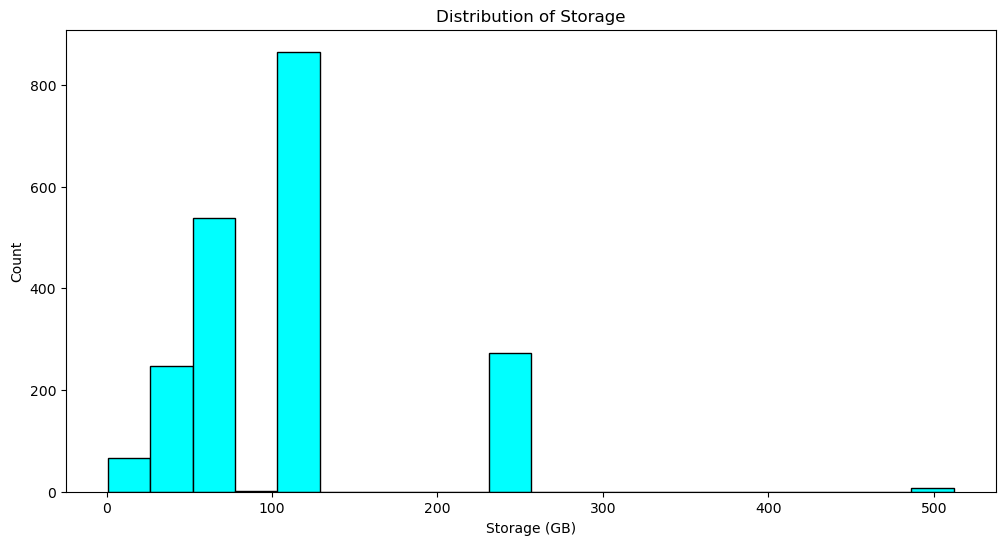

In [3141]:
plt.figure(figsize=(12, 6))
plt.hist(mobiles_clean['storage'], bins=20, edgecolor='black', color='#00FFFF')
plt.title('Distribution of Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Count')
plt.show()

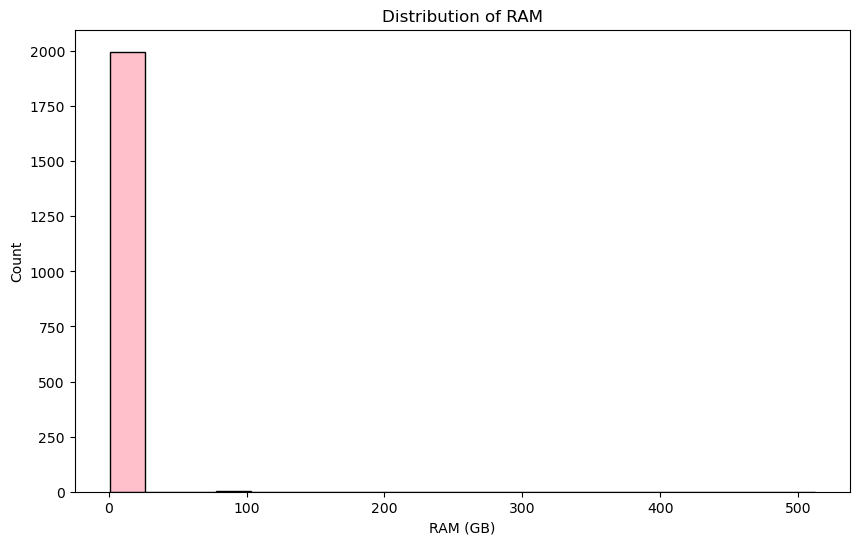

In [3142]:
plt.figure(figsize=(10, 6))
plt.hist(mobiles_clean['ram'].dropna(), bins=20, edgecolor='black',color='#FFC0CB') 
plt.title('Distribution of RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Count')
plt.show()

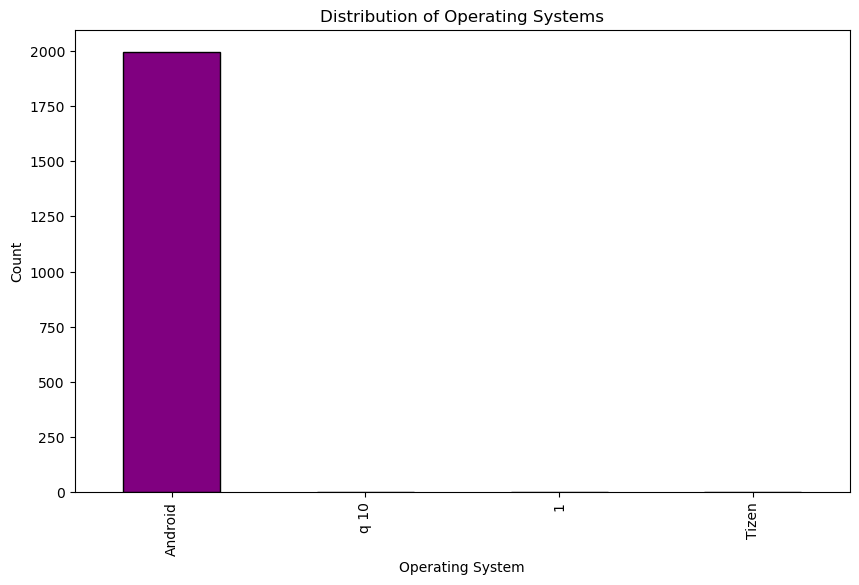

In [3143]:
plt.figure(figsize=(10, 6))
mobiles_clean['system'].value_counts().plot(kind='bar',edgecolor='black',color='#800080')
plt.title('Distribution of Operating Systems')
plt.xlabel('Operating System')
plt.ylabel('Count')
plt.show()

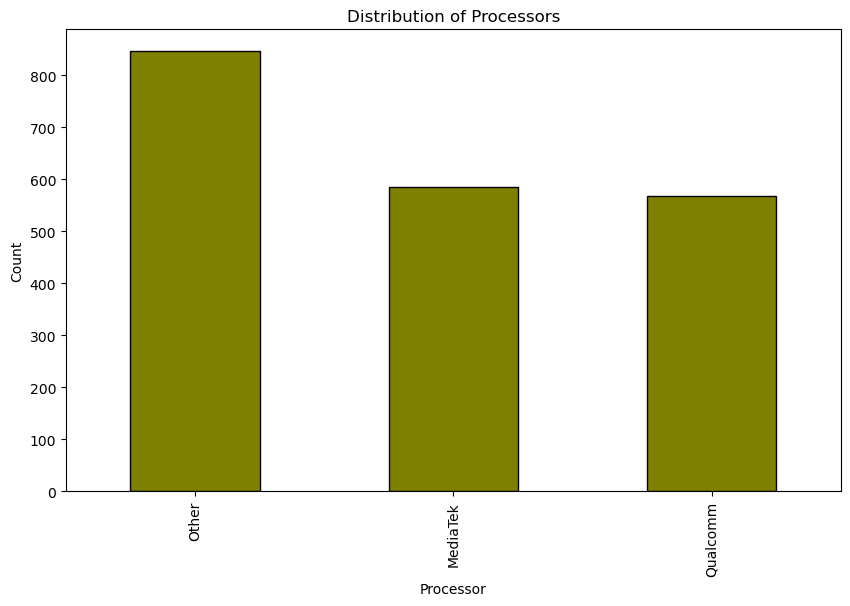

In [3144]:
plt.figure(figsize=(10, 6))
mobiles_clean['processor'].value_counts().plot(kind='bar',edgecolor='black',color='#808000')
plt.title('Distribution of Processors')
plt.xlabel('Processor')
plt.ylabel('Count')
plt.show()

In [3145]:
def clean_price(price):
    if isinstance(price, (int, float)):  # If the price is already numeric
        return int(price)
    if isinstance(price, str):  # If the price is a string
        cleaned_price = re.sub(r'[^\d]', '', price)  # Remove all non-numeric characters
        if cleaned_price:
            return int(cleaned_price)
    return None 

In [3146]:
mobiles_clean.loc[:,'price'] = mobiles_clean['price'].apply(clean_price)

In [3147]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage,ram,system,processor,battery_capacity,display_size,resolution,processor_speed,camera,network,operating_system
0,"redmi note 12 pro 5g (onyx black, 128 gb)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0,6.0,Android,MediaTek,5000,16.94cm,2400 x 1080 pixels,2.6,50mp,5G,android 12processor typemediatek dimensity 108...
1,"oppo f11 pro (aurora green, 128 gb)",4.5,20999,https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0,6.0,Android,MediaTek,4000,16.51cm,2340 x 1080 pixels,2.1,48mp,3G,android pie 9
2,"redmi note 11 (starburst white, 64 gb)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0,4.0,Android,Other,5000,16.33cm,2400 x 1080,2.4,50mp,4G,android 11processor speed2
3,"oneplus nord ce 5g (blue void, 256 gb)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0,12.0,Android,Qualcomm,4500,16.33cm,2400 x 1080,2.4,64mp,5G,android q 11processor typequalcomm snapdragon ...
6,"redmi 10 power (sporty orange, 128 gb)",4.2,18996,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram8 systemandroid 13processor s...,128.0,8.0,Android,Other,6000,17.02cm,2400 x 1080,2.4,50mp,4G,android 13processor speed2


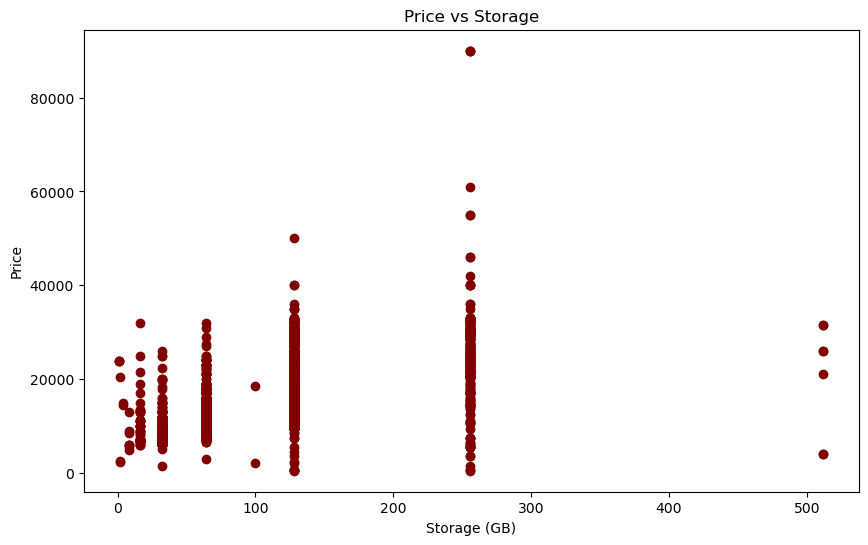

In [3148]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['storage'], mobiles_clean['price'], color='#800000')
plt.title('Price vs Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Price')
plt.show()

In [3149]:
correlation = mobiles_clean['price'].corr(mobiles_clean['storage'])

correlation

0.5397554855697059

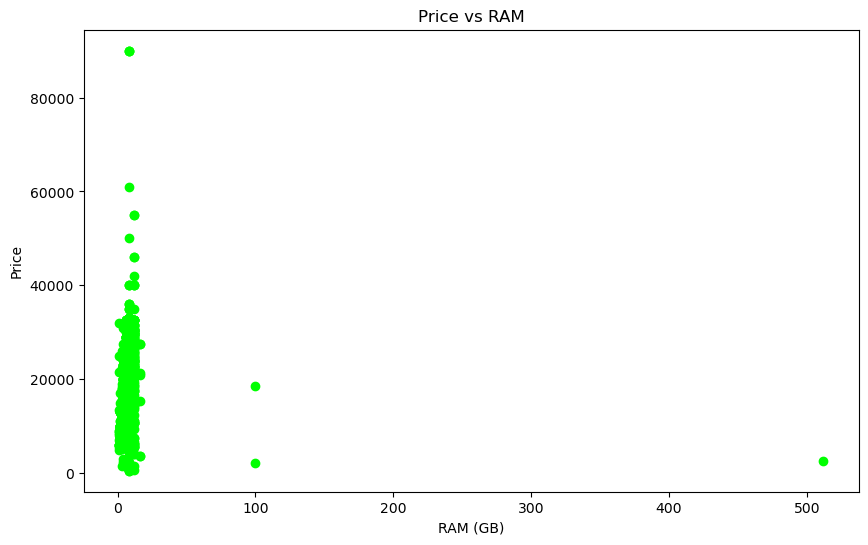

In [3150]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['ram'], mobiles_clean['price'], color='#00FF00')
plt.title('Price vs RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Price')
plt.show()

In [3151]:
correlation = mobiles_clean['price'].corr(mobiles_clean['ram'])

correlation

0.08515973249929816

In [3152]:
avg_price_system = mobiles_clean.groupby('system')['price'].mean()

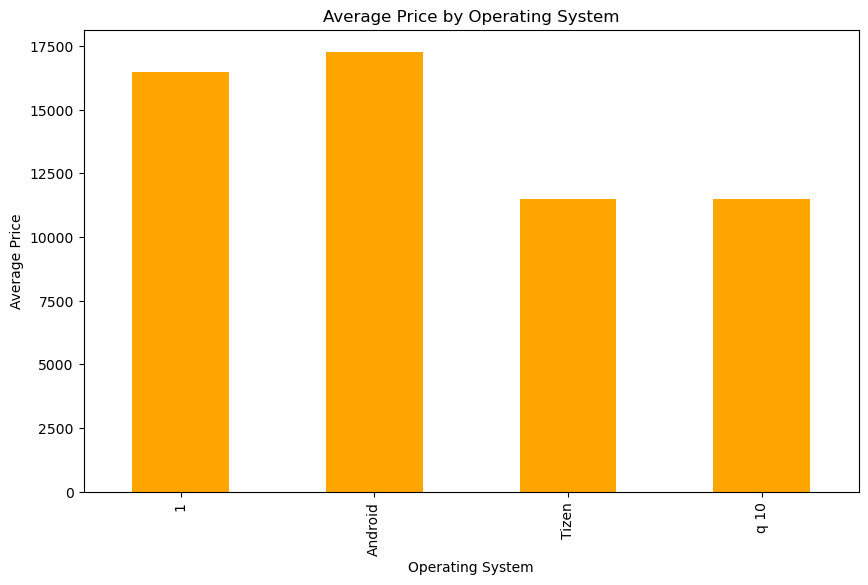

In [3153]:
plt.figure(figsize=(10, 6))
avg_price_system.plot(kind='bar',color='#FFA500')
plt.title('Average Price by Operating System')
plt.xlabel('Operating System')
plt.ylabel('Average Price')
plt.show()

In [3154]:
avg_price_processor = mobiles_clean.groupby('processor')['price'].mean()

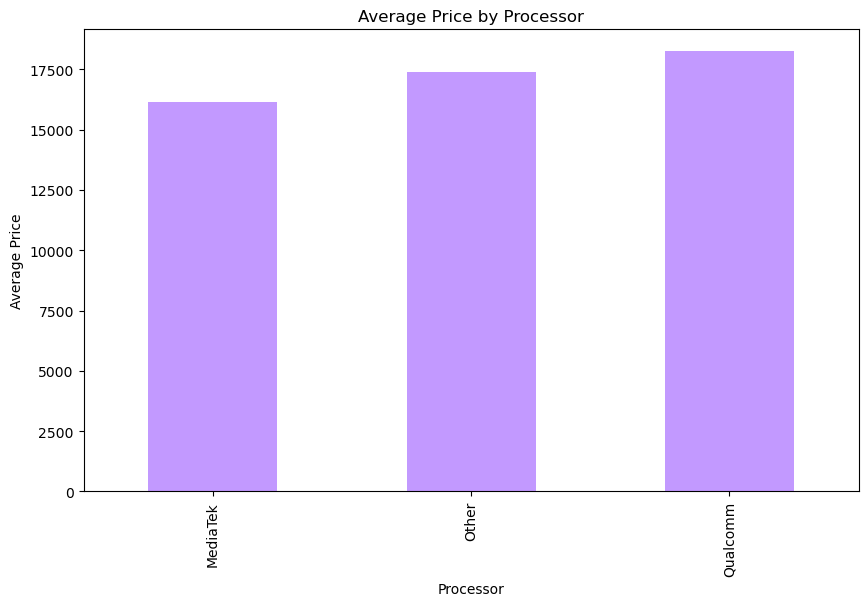

In [3155]:
plt.figure(figsize=(10, 6))
avg_price_processor.plot(kind='bar',color='#C299FF')
plt.title('Average Price by Processor')
plt.xlabel('Processor')
plt.ylabel('Average Price')
plt.show()

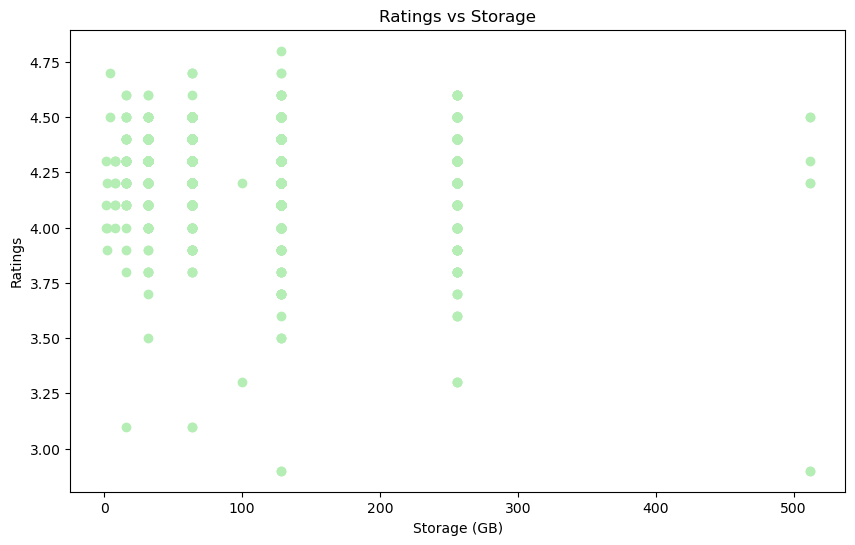

In [3156]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['storage'], mobiles_clean['ratings'], color='#B4EEB4')
plt.title('Ratings vs Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Ratings')
plt.show()

In [3157]:
correlation = mobiles_clean['ratings'].corr(mobiles_clean['storage'])

correlation

-0.09550171700546535

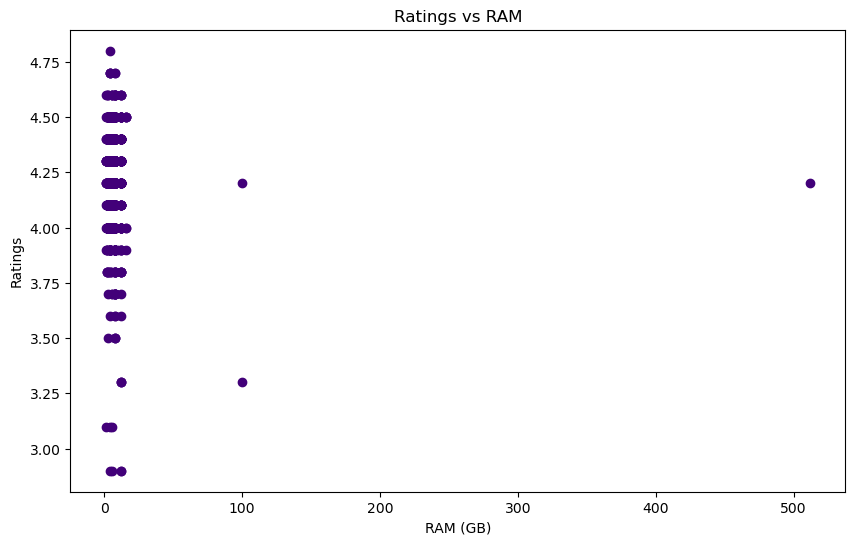

In [3158]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['ram'], mobiles_clean['ratings'], color='#420079')
plt.title('Ratings vs RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Ratings')
plt.show()

In [3159]:
correlation = mobiles_clean['ratings'].corr(mobiles_clean['ram'])

correlation

-0.04407997692232844

In [3160]:
avg_rating_system = mobiles_clean.groupby('system')['ratings'].mean()

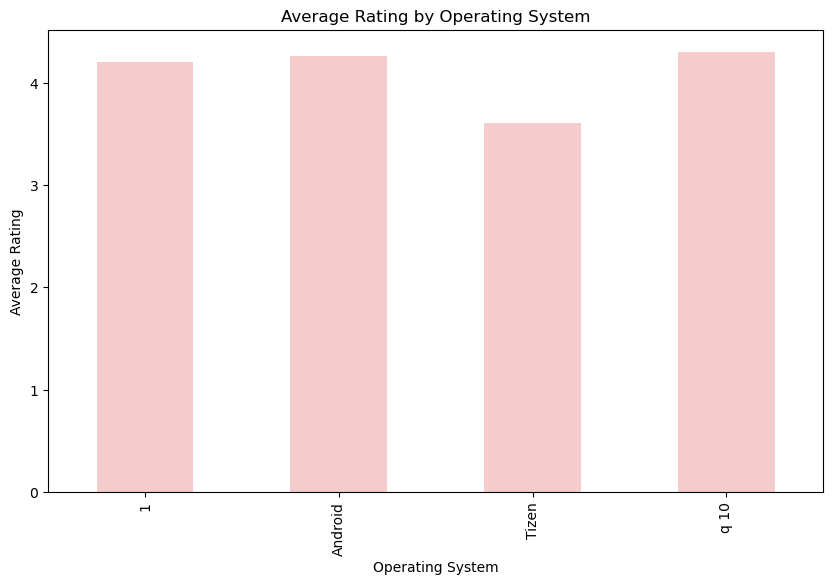

In [3161]:
plt.figure(figsize=(10, 6))
avg_rating_system.plot(kind='bar', color='#F4CCCC')
plt.title('Average Rating by Operating System')
plt.xlabel('Operating System')
plt.ylabel('Average Rating')
plt.show()

In [3162]:
avg_rating_processor = mobiles_clean.groupby('processor')['ratings'].mean()

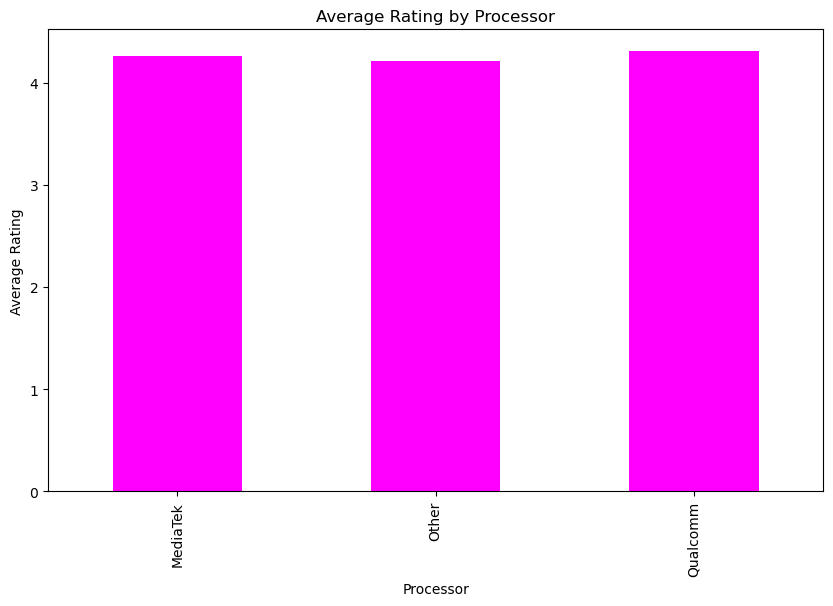

In [3163]:
plt.figure(figsize=(10, 6))
avg_rating_processor.plot(kind='bar', color='#FF00FF')
plt.title('Average Rating by Processor')
plt.xlabel('Processor')
plt.ylabel('Average Rating')
plt.show()

In [3164]:
def extract_brand(name):
    return name.split()[0]

In [3165]:
mobiles_clean.loc[:,'brand'] = mobiles_clean['name'].apply(extract_brand)

In [3166]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage,ram,system,processor,battery_capacity,display_size,resolution,processor_speed,camera,network,operating_system,brand
0,"redmi note 12 pro 5g (onyx black, 128 gb)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0,6.0,Android,MediaTek,5000,16.94cm,2400 x 1080 pixels,2.6,50mp,5G,android 12processor typemediatek dimensity 108...,redmi
1,"oppo f11 pro (aurora green, 128 gb)",4.5,20999,https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0,6.0,Android,MediaTek,4000,16.51cm,2340 x 1080 pixels,2.1,48mp,3G,android pie 9,oppo
2,"redmi note 11 (starburst white, 64 gb)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0,4.0,Android,Other,5000,16.33cm,2400 x 1080,2.4,50mp,4G,android 11processor speed2,redmi
3,"oneplus nord ce 5g (blue void, 256 gb)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0,12.0,Android,Qualcomm,4500,16.33cm,2400 x 1080,2.4,64mp,5G,android q 11processor typequalcomm snapdragon ...,oneplus
6,"redmi 10 power (sporty orange, 128 gb)",4.2,18996,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram8 systemandroid 13processor s...,128.0,8.0,Android,Other,6000,17.02cm,2400 x 1080,2.4,50mp,4G,android 13processor speed2,redmi


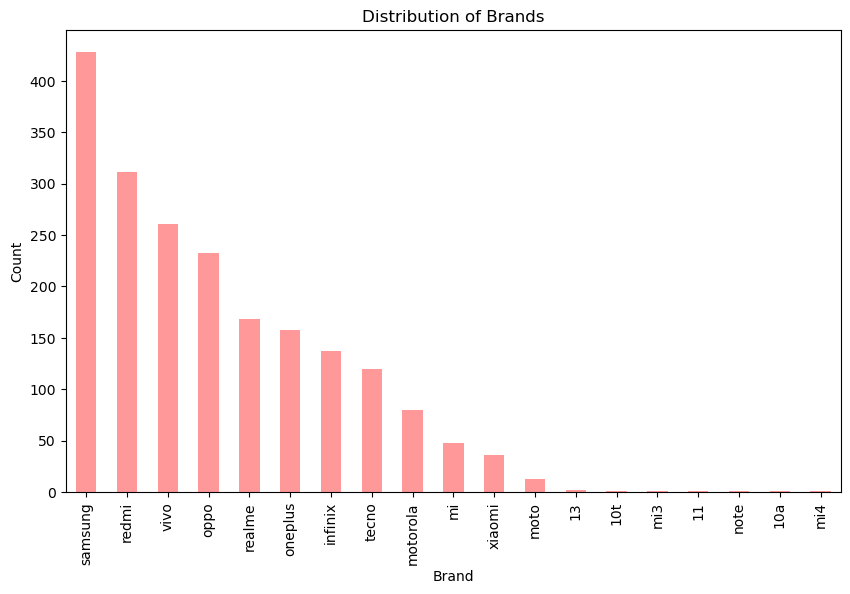

In [3167]:
plt.figure(figsize=(10, 6))
mobiles_clean['brand'].value_counts().plot(kind='bar',color='#ff9999')
plt.title('Distribution of Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

In [3168]:
avg_price_brand = mobiles_clean.groupby('brand')['price'].mean()

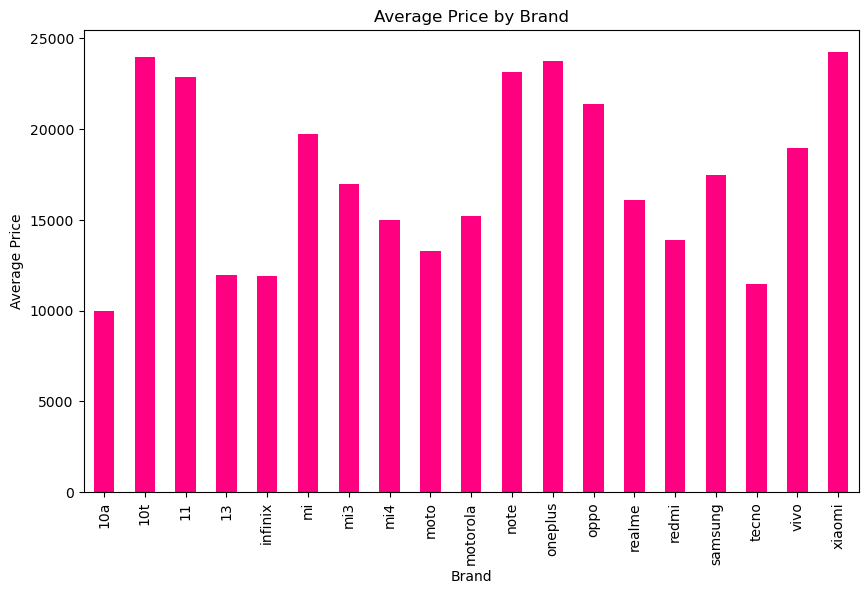

In [3169]:
plt.figure(figsize=(10, 6))
avg_price_brand.plot(kind='bar',color='#ff0080')
plt.title('Average Price by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.show()

In [3170]:
avg_rating_brand = mobiles_clean.groupby('brand')['ratings'].mean()

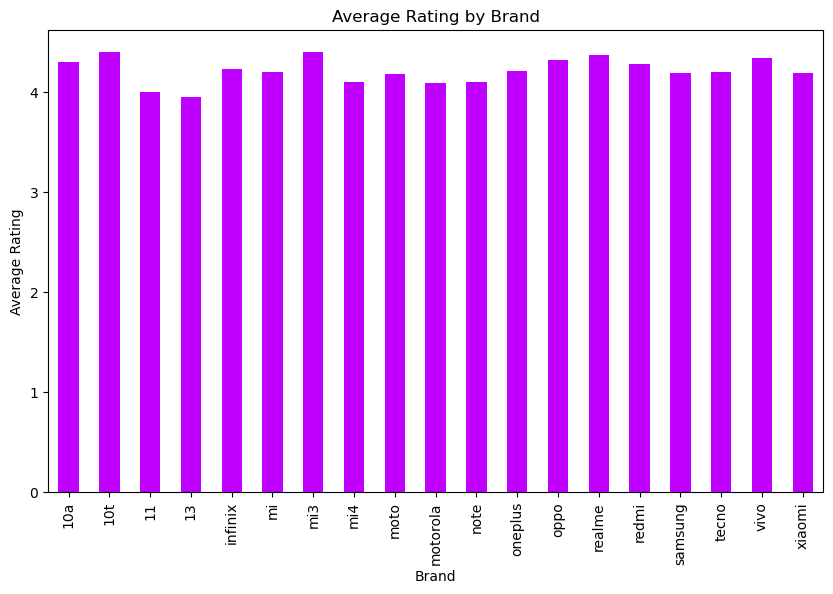

In [3171]:
plt.figure(figsize=(10, 6))
avg_rating_brand.plot(kind='bar' ,color='#bf00ff')
plt.title('Average Rating by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.show()

In [3172]:
mobiles_clean.columns

Index(['name', 'ratings', 'price', 'imgURL', 'corpus', 'storage', 'ram',
       'system', 'processor', 'battery_capacity', 'display_size', 'resolution',
       'processor_speed', 'camera', 'network', 'operating_system', 'brand'],
      dtype='object')

In [3173]:
numeric_features = ['storage', 'ram', 'price', 'ratings', 'battery_capacity', 'processor_speed']
categorical_features = ['system', 'processor', 'brand', 'camera', 'network', 'operating_system', 'display_size']

In [3174]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [3175]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [3176]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [3177]:
max_len = 0
for i in range(0, len(mobiles_clean['corpus'])):
    try:
        if len(mobiles_clean['corpus'][i]) > max_len:
            max_len = len(mobiles_clean['corpus'][i])
    except:
        pass

print(f'words max len in corpus is: {max_len}')

words max len in corpus is: 1199


In [3178]:
#convert text to matrix
from sklearn.feature_extraction.text import CountVectorizer  

In [3179]:
corpus = mobiles_clean['corpus'].astype(str).tolist() 

In [3180]:
#limit the number of words to consider
cont_vect = CountVectorizer(max_features=1000)

In [3181]:
X = cont_vect.fit_transform(corpus)
vectors = X.toarray()

In [3182]:
feature_names=cont_vect.get_feature_names_out()

In [3183]:
feature_names

array(['000', '02', '03', '04', '05', '05mm', '07', '07bother', '08',
       '09', '0mp', '0processor', '10', '100', '1000', '100000',
       '1000000', '1000mhzdisplay', '100mp', '103', '104', '106', '1080',
       '1080processor', '1080resolution', '108mp', '10mp', '10processor',
       '11', '1100', '11processor', '12', '120', '1200', '1200processor',
       '120hz', '1280processor', '12mp', '12processor', '13', '1300',
       '1300processor', '1330', '135', '135hz', '1380', '13mp',
       '13processor', '1400', '144', '1440', '144hz', '144hzother',
       '1480', '15', '1500', '1500nits', '1520', '1544', '1560resolution',
       '16', '1600', '16000', '1600resolution', '1612', '1640', '16mp',
       '18', '180', '180hz', '19', '1920hz', '1processor', '20',
       '2000000', '200mp', '20mp', '21', '22', '23', '2340', '24', '240',
       '2400', '2400resolution', '2408', '240hz', '2460', '24mp', '25mm',
       '25mp', '26', '27', '28', '2d', '2g', '2ghzprocessor', '2k', '2mm',
      

In [3184]:
#from vectors matrix shape
similarity = cosine_similarity(vectors)
similarity.shape

(2000, 2000)

In [3185]:
#cosine similarity between the 4th row and all other rows, including itself
similarity[3]

array([0.3345748 , 0.17429787, 0.53136893, ..., 0.57564968, 0.2732972 ,
       0.37283655])

In [3186]:
#sorts the similarity scores of the 1st row with respect to all other rows, excluding the row itself
#retrieves the top 10 most similar rows
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:11]

[(59, 0.9999999999999997),
 (240, 0.9999999999999997),
 (481, 0.9850746268656714),
 (1147, 0.9850746268656714),
 (368, 0.970149253731343),
 (804, 0.970149253731343),
 (1364, 0.970149253731343),
 (449, 0.9468131937613654),
 (881, 0.9468131937613654),
 (1209, 0.9468131937613654)]

In [3187]:
def recommend(mobile):
    # Find the index of the given mobile
    mobile_indices = mobiles_clean[mobiles_clean['name'] == mobile].index
    
    # Check if the mobile exists in the DataFrame
    if mobile_indices.empty:
        print(f"The mobile '{mobile}' is not found in the database.")
        return
    
    mobile_index = mobile_indices[0]  # Get the first index if it exists
    
    # Retrieve similarity scores
    similarity_array = similarity[mobile_index]
    
    # Find top 10 similar mobiles
    similar_10_mobiles = sorted(list(enumerate(similarity_array)), reverse=True, key=lambda x: x[1])[1:11]
    
    # Print the names of the top 10 similar mobiles
    for i in similar_10_mobiles:
        print(mobiles_clean['name'].iloc[i[0]])

In [3188]:
recommend('redmi note 12 pro 5g (stardust purple, 128 gb)')

motorola e7 power (coral red, 32 gb)
motorola e7 power (tahiti blue, 64 gb)
motorola e7 power (coral red, 64 gb)
motorola g8 power lite (arctic blue, 64 gb)
vivo y15s (wave green, 32 gb)
vivo y15s (mystic blue, 32 gb)
vivo y3s (mint green, 32 gb)
vivo y3s (pearl white, 32 gb)
vivo y3s (starry blue, 32 gb)
motorola g9 (sapphire blue, 64 gb)


In [3189]:
def random_values(df:mobiles_clean,col_name:str,total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(0,total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index,':',mobiles_clean[col_name].iloc[index])  

In [3190]:
random_values(mobiles_clean,'corpus')

1908 : storage64 gbram4  systemandroid 11processor typequalcomm snapdragon 732gprocessor speed2.3 64mp 8mp 2mp 16mp 4g capacity6000 display size17.22 cm (6.78 inch)resolution2460 x 1080 pixelsresolution typefull hd+display typefull hd+ ips lcd displayother display features120hz refresh rate, 20.5:9 display aspect ratio, active area-touch panel (aa-tp): 84.69%, anti fingerprint coating, water repellent design, hdr10
15 : storage128 gbram8  systemandroid 10processor typequalcomm snapdragon 865processor speed2.84 108mp 13mp 5mp 108mp 13mp 5mp 108mp 13mp 5mp 20mp 5g capacity5000 display size16.94 cm (6.67 inch)resolution2400 x 1080 pixelsresolution typefull hd+gpuadreno 650display typefull hd+ displayhd game supportyesother display featuresscreen protection: triple corning gorilla glass 5 covering front, back and camera lenses, 144 hz refresh rate, supports adaptive sync in 30hz / 48hz / 50hz / 60hz / 90hz / 120hz / 144hz, 96% (typ) ntsc color gamut, 98% (typ) dci-p3, truecolor display, su

In [3191]:
# Get cosine similarity scores for a specific mobile 
target_mobile_index = 3
predicted_scores = similarity[target_mobile_index]

In [3192]:
# Set a relevance threshold 
threshold = 0.75
y_pred = np.where(predicted_scores >= threshold, 1, 0)  # Predicted relevant (1) or irrelevant (0)

# Define a function to compute true relevance based on similar specs
def get_relevance(target_mobile, comparison_mobile):
    score = 0
    if target_mobile['ram'] == comparison_mobile['ram']:
        score += 0.1  # Add weight for RAM similarity
    if target_mobile['storage'] == comparison_mobile['storage']:
        score += 0.2  # Add weight for Storage similarity
    if target_mobile['processor'] == comparison_mobile['processor']:
        score += 0.3  # Add weight for Processor similarity
    if target_mobile['brand'] == comparison_mobile['brand']:
        score += 0.4  # Add weight for Brand similarity
    
    # Add more comparisons for other features
    if target_mobile['battery_capacity'] == comparison_mobile['battery_capacity']:
        score += 0.1  # Weight for Battery Capacity similarity
    if target_mobile['display_size'] == comparison_mobile['display_size']:
        score += 0.1  # Weight for Display Size similarity
    if target_mobile['processor_speed'] == comparison_mobile['processor_speed']:
        score += 0.1  # Weight for Processor Speed similarity
    # if target_mobile['weight'] == comparison_mobile['weight']:
    #     score += 0.1  # Weight for Weight similarity
    #if target_mobile['processor_type'] == comparison_mobile['processor_type']:
        score += 0.1  # Weight for Processor Type similarity
    if target_mobile['camera'] == comparison_mobile['camera']:
        score += 0.1  # Weight for Camera similarity
    if target_mobile['network'] == comparison_mobile['network']:
        score += 0.1  # Weight for Network similarity
    if target_mobile['operating_system'] == comparison_mobile['operating_system']:
        score += 0.1  # Weight for Operating System similarity

    return 1 if score >= 0.75 else 0

# Generate true relevance labels (y_true) based on specs similarity for all other mobiles
target_mobile = mobiles_clean.iloc[target_mobile_index]
y_true = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Print Predicted and True Labels
print(f"Predicted relevance labels based on cosine similarity: {y_pred}")
print(f"True relevance labels based on specs similarity: {y_true}")

# Evaluate Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))

# Evaluate MAE and RMSE (if you're working with continuous similarity scores as well)
mae = mean_absolute_error(y_true, predicted_scores)  # Using continuous similarity for y_pred
rmse = np.sqrt(mean_squared_error(y_true, predicted_scores))

print(f"MAE: {mae}, RMSE: {rmse}")

def random_values(df, col_name, total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index, ':', mobiles_clean[col_name].iloc[index])

random_values(mobiles_clean, 'corpus')

Predicted relevance labels based on cosine similarity: [0 0 0 ... 0 0 0]
True relevance labels based on specs similarity: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [3193]:
def get_relevance(target_mobile, comparison_mobile):
    score = 0
    if target_mobile['ram'] == comparison_mobile['ram']:
        score += 0.2  # Increased weight for RAM similarity
    if target_mobile['storage'] == comparison_mobile['storage']:
        score += 0.3  # Increased weight for Storage similarity
    if target_mobile['processor'] == comparison_mobile['processor']:
        score += 0.4  # Increased weight for Processor similarity
    if target_mobile['brand'] == comparison_mobile['brand']:
        score += 0.5  # Increased weight for Brand similarity

    # Additional comparisons with adjusted weights
    if target_mobile['battery_capacity'] == comparison_mobile['battery_capacity']:
        score += 0.1
    if target_mobile['display_size'] == comparison_mobile['display_size']:
        score += 0.1
    if target_mobile['processor_speed'] == comparison_mobile['processor_speed']:
        score += 0.1
    # if target_mobile['weight'] == comparison_mobile['weight']:
    #     score += 0.1
    if target_mobile['camera'] == comparison_mobile['camera']:
        score += 0.1
    if target_mobile['network'] == comparison_mobile['network']:
        score += 0.1
    if target_mobile['operating_system'] == comparison_mobile['operating_system']:
        score += 0.1

    return 1 if score >= 0.6 else 0  # Lowered threshold for relevance

# Generate true relevance labels (y_true) based on specs similarity for all other mobiles
target_mobile = mobiles_clean.iloc[target_mobile_index]
y_true = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Print Predicted and True Labels
print(f"Predicted relevance labels based on cosine similarity: {y_pred}")
print(f"True relevance labels based on specs similarity: {y_true}")

# Evaluate Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))

# Evaluate MAE and RMSE (if you're working with continuous similarity scores as well)
mae = mean_absolute_error(y_true, predicted_scores)  # Using continuous similarity for y_pred
rmse = np.sqrt(mean_squared_error(y_true, predicted_scores))

print(f"MAE: {mae}, RMSE: {rmse}")

def random_values(df, col_name, total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index, ':', mobiles_clean[col_name].iloc[index])

random_values(mobiles_clean, 'corpus')


Predicted relevance labels based on cosine similarity: [0 0 0 ... 0 0 0]
True relevance labels based on specs similarity: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [3194]:
from sklearn.metrics import roc_curve, auc

# Assuming `predicted_scores` contains the continuous relevance scores
fpr, tpr, thresholds = roc_curve(y_true, predicted_scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold based on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')


Optimal threshold: 0.34426518632954817


In [3195]:
def get_relevance(target_mobile, comparison_mobile):
    score = 0
    if target_mobile['ram'] == comparison_mobile['ram']:
        score += 0.25  # Increased weight for RAM similarity
    if target_mobile['storage'] == comparison_mobile['storage']:
        score += 0.3  # Increased weight for Storage similarity
    if target_mobile['processor'] == comparison_mobile['processor']:
        score += 0.4  # Increased weight for Processor similarity
    if target_mobile['brand'] == comparison_mobile['brand']:
        score += 0.5  # Increased weight for Brand similarity

    # Additional comparisons with adjusted weights
    if target_mobile['battery_capacity'] == comparison_mobile['battery_capacity']:
        score += 0.1
    if target_mobile['display_size'] == comparison_mobile['display_size']:
        score += 0.1
    if target_mobile['processor_speed'] == comparison_mobile['processor_speed']:
        score += 0.1
    # if target_mobile['weight'] == comparison_mobile['weight']:
    #     score += 0.1
    if target_mobile['camera'] == comparison_mobile['camera']:
        score += 0.1
    if target_mobile['network'] == comparison_mobile['network']:
        score += 0.1
    if target_mobile['operating_system'] == comparison_mobile['operating_system']:
        score += 0.1

    return 1 if score >= 0.312 else 0  # Updated threshold for relevance

# Generate true relevance labels (y_true) based on specs similarity for all other mobiles
target_mobile = mobiles_clean.iloc[target_mobile_index]
y_true = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Print Predicted and True Labels
print(f"Predicted relevance labels based on cosine similarity: {y_pred}")
print(f"True relevance labels based on specs similarity: {y_true}")

# Evaluate Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))

# Evaluate MAE and RMSE (if you're working with continuous similarity scores as well)
mae = mean_absolute_error(y_true, predicted_scores)  # Using continuous similarity for y_pred
rmse = np.sqrt(mean_squared_error(y_true, predicted_scores))

print(f"MAE: {mae}, RMSE: {rmse}")

def random_values(df, col_name, total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index, ':', mobiles_clean[col_name].iloc[index])

random_values(mobiles_clean, 'corpus')


Predicted relevance labels based on cosine similarity: [0 0 0 ... 0 0 0]
True relevance labels based on specs similarity: [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0

In [3196]:
def get_relevance(target_mobile, comparison_mobile):
    score = 0
    # Increased weights for more significant features
    if target_mobile['ram'] == comparison_mobile['ram']:
        score += 0.3  # Increased weight for RAM similarity
    if target_mobile['storage'] == comparison_mobile['storage']:
        score += 0.4  # Increased weight for Storage similarity
    if target_mobile['processor'] == comparison_mobile['processor']:
        score += 0.5  # Increased weight for Processor similarity
    if target_mobile['brand'] == comparison_mobile['brand']:
        score += 0.6  # Increased weight for Brand similarity

    # Additional comparisons with modified weights
    if target_mobile['battery_capacity'] == comparison_mobile['battery_capacity']:
        score += 0.15  # Slightly increased
    if target_mobile['display_size'] == comparison_mobile['display_size']:
        score += 0.1
    if target_mobile['processor_speed'] == comparison_mobile['processor_speed']:
        score += 0.1
    # if target_mobile['weight'] == comparison_mobile['weight']:
    #     score += 0.1
    if target_mobile['camera'] == comparison_mobile['camera']:
        score += 0.1
    if target_mobile['network'] == comparison_mobile['network']:
        score += 0.1
    if target_mobile['operating_system'] == comparison_mobile['operating_system']:
        score += 0.1

    # Consider additional features
    # if target_mobile['price'] <= comparison_mobile['price']:  # Example for price
    #     score += 0.1
    # if target_mobile['release_year'] >= comparison_mobile['release_year']:  # Example for release year
    #     score += 0.1

    # Change threshold based on new scoring
    return 1 if score >= 0.4 else 0  # Adjusted threshold for relevance
# Generate true relevance labels (y_true) based on specs similarity for all other mobiles
target_mobile = mobiles_clean.iloc[target_mobile_index]
y_true = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Print Predicted and True Labels
print(f"Predicted relevance labels based on cosine similarity: {y_pred}")
print(f"True relevance labels based on specs similarity: {y_true}")

# Evaluate Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))

# Evaluate MAE and RMSE (if you're working with continuous similarity scores as well)
mae = mean_absolute_error(y_true, predicted_scores)  # Using continuous similarity for y_pred
rmse = np.sqrt(mean_squared_error(y_true, predicted_scores))

print(f"MAE: {mae}, RMSE: {rmse}")

def random_values(df, col_name, total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index, ':', mobiles_clean[col_name].iloc[index])

random_values(mobiles_clean, 'corpus')


Predicted relevance labels based on cosine similarity: [0 0 0 ... 0 0 0]
True relevance labels based on specs similarity: [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

In [3197]:
def get_relevance(target_mobile, comparison_mobile):
    score = 0
    # Weights for significant features
    if target_mobile['ram'] == comparison_mobile['ram']:
        score += 0.3
    if target_mobile['storage'] == comparison_mobile['storage']:
        score += 0.4
    if target_mobile['processor'] == comparison_mobile['processor']:
        score += 0.5
    if target_mobile['brand'] == comparison_mobile['brand']:
        score += 0.6

    # Additional comparisons with modified weights
    if target_mobile['battery_capacity'] == comparison_mobile['battery_capacity']:
        score += 0.15
    if target_mobile['display_size'] == comparison_mobile['display_size']:
        score += 0.1
    if target_mobile['processor_speed'] == comparison_mobile['processor_speed']:
        score += 0.1
    # if target_mobile['weight'] == comparison_mobile['weight']:
    #     score += 0.1
    if target_mobile['camera'] == comparison_mobile['camera']:
        score += 0.1
    if target_mobile['network'] == comparison_mobile['network']:
        score += 0.1
    if target_mobile['operating_system'] == comparison_mobile['operating_system']:
        score += 0.1

    # Price comparison
    price_difference = abs(target_mobile['price'] - comparison_mobile['price'])
    price_weight = 0.0

    # Adjusted thresholds
    if price_difference <= 10:
        price_weight = 0.4
    elif price_difference <= 30:
        price_weight = 0.3
    elif price_difference <= 60:
        price_weight = 0.2
    elif price_difference <= 120:
        price_weight = 0.1

    score += price_weight

    # Change threshold based on new scoring
    return 1 if score >= 0.4 else 0  # Lowered threshold for relevance


# Generate true relevance labels (y_true) based on specs similarity for all other mobiles
target_mobile = mobiles_clean.iloc[target_mobile_index]
y_true = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Print Predicted and True Labels
print(f"Predicted relevance labels based on cosine similarity: {y_pred}")
print(f"True relevance labels based on specs similarity: {y_true}")

# Evaluate Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))

# Evaluate MAE and RMSE (if you're working with continuous similarity scores as well)
mae = mean_absolute_error(y_true, predicted_scores)  # Using continuous similarity for y_pred
rmse = np.sqrt(mean_squared_error(y_true, predicted_scores))

print(f"MAE: {mae}, RMSE: {rmse}")

def random_values(df, col_name, total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index, ':', mobiles_clean[col_name].iloc[index])

random_values(mobiles_clean, 'corpus')


Predicted relevance labels based on cosine similarity: [0 0 0 ... 0 0 0]
True relevance labels based on specs similarity: [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0

In [3198]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have your mobile DataFrame as 'mobiles_clean'
# Select your features and labels
X = mobiles_clean[['ram', 'storage', 'processor', 'brand', 'battery_capacity', 
                   'display_size', 'processor_speed', 'camera', 
                   'network', 'operating_system', 'price']]

# Encode categorical variables using One-Hot Encoding
X = pd.get_dummies(X, columns=['processor', 'brand', 'operating_system', 'network', 'display_size', 'camera'], drop_first=True)

# Create labels (y)
y = [get_relevance(target_mobile, mobiles_clean.iloc[i]) for i in range(len(mobiles_clean))]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['irrelevant', 'relevant']))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

  irrelevant       0.99      1.00      1.00       227
    relevant       1.00      0.99      0.99       173

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

Accuracy: 0.99


In [3199]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the balanced data
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['irrelevant', 'relevant']))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

  irrelevant       0.99      1.00      0.99       227
    relevant       0.99      0.99      0.99       173

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Accuracy: 0.99


In [3200]:
# Train a Random Forest Classifier with class weight
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 5})  # Adjust weights as necessary
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['irrelevant', 'relevant']))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

  irrelevant       0.98      1.00      0.99       227
    relevant       1.00      0.97      0.99       173

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Accuracy: 0.99


In [3201]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [{0: 1, 1: 5}, 'balanced']  # Class weights
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['irrelevant', 'relevant']))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

  irrelevant       0.98      1.00      0.99       227
    relevant       1.00      0.98      0.99       173

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Accuracy: 0.99


In [3209]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Optional: Displaying actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nActual vs Predicted values:")
print(results.head(10))


Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.1
R-squared (R2): 0.9592574673423137

Actual vs Predicted values:
   Actual  Predicted
0       1          1
1       0          0
2       1          1
3       0          0
4       0          0
5       0          0
6       1          1
7       1          1
8       1          1
9       0          0


In [3211]:
#mobiles_clean.to_csv('data/mobile_processed_data.csv', index=False)

In [3213]:
#create directories recursively
os.makedirs(r'src\model',exist_ok=True)

In [3215]:
#save the dataframe toa file
pickle.dump(obj=mobiles_clean,file=open(file=r'src\model\dataframe.pkl',mode='wb'))

In [3217]:
pickle.dump(obj=similarity,file=open(file=r'src\model\similarity.pkl',mode='wb'))